In [143]:
#Define Constante
DIR = "/content/drive/MyDrive/Colab Notebooks/UPM/PRDL/EDA/"

#importation
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from google.colab import drive
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model, svm, neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import math

## Accessing the data

In [23]:
def importData():
  drive.mount("/content/drive")
  
  #Change directory
  os.chdir(DIR)

  # Read Clinical Data
  OSA_Clinical_df = pd.read_csv("OSA_DB_UPM_Clinical.csv",sep=';',na_values=['-1'])
  OSA_Clinical_df=OSA_Clinical_df.dropna()

  # Now Read Demographical Information
  OSA_Demo_df = pd.read_csv("OSA_DB_UPM_Age_Gender.csv",na_values=['-1'])
  OSA_Demo_df=OSA_Demo_df.dropna()

  # JOIN OSA_Demo_df and OSA_Clinical_df
  OSA_df = pd.merge(OSA_Clinical_df, OSA_Demo_df, on='ID', how='inner')

  OSA_df['ID'] = OSA_df['ID'].astype('str')
  OSA_df = OSA_df.set_index('ID')
  return OSA_df

# Data analyses, EDA

In [24]:
df = importData()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


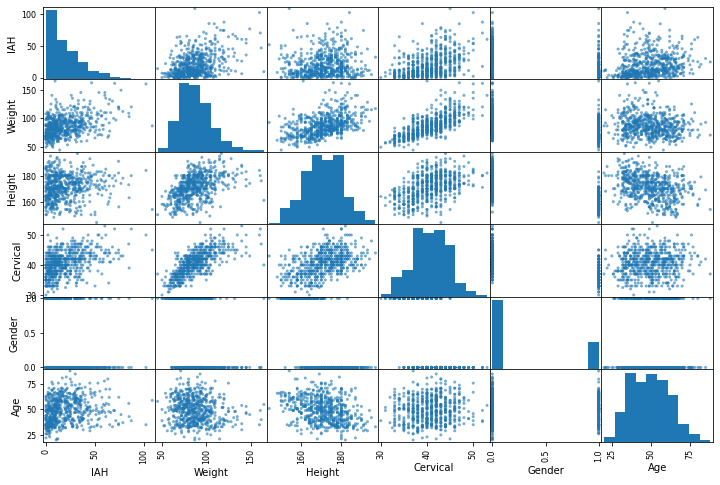

In [25]:
axes = scatter_matrix(df, alpha=0.6, figsize=(12, 8), diagonal='hist')

In [26]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Individual linear regression on Age, Weight, Height and Cervical

In [79]:
def linear_hypotheses_test(predictor):
  target = 'IAH'
  # Define the model
  model = linear_model.LinearRegression()
  model.fit(df[predictor], df[target])
  param = model.coef_[0]
  predictions = model.predict(df[predictor])
  sigma_squared = (df[target]-predictions).var()
  Sxx = ((df[predictor]-df[predictor].mean())**2).sum()
  SE = np.sqrt(sigma_squared/Sxx)
  #print(param/SE)
  p_value = 2*stats.t.cdf(-np.abs(param/SE), len(predictions)-2)
  return p_value

In [90]:
def independant_hypoteses_test(predictor):
  target = 'IAH'
  # Define the model
  Sxx = ((df[predictor]-df[predictor].mean())**2).sum()
  Syy = ((df[target]-df[target].mean())**2).sum()
  Sxy = ((df[predictor]-df[predictor].mean())*(df[target]-df[target].mean())).sum()
  R = Sxy/np.sqrt(Sxx*Syy)
  n = len(df[predictor])
  val = R*np.sqrt(n-2)/np.sqrt(1-R**2)
  #print(param/SE)
  print(val)
  p_value = 2*stats.t.cdf(-abs(val), n-2)
  return p_value

In [91]:
predictors = ['Weight', 'Height', 'Cervical', 'Age']
for predictor in predictors:
  linear_p_value = linear_hypotheses_test([predictor])
  independant_p_value = independant_hypoteses_test(predictor)
  print("Test on :", predictor, "p_value of linear relation =", linear_p_value,
        "p_value of independency =", independant_p_value,)

10.897050813978742
Test on : Weight p_value of linear relation = [2.22228733e-25] p_value of independency = 2.4161184944908805e-25
2.5657526745565815
Test on : Height p_value of linear relation = [0.01047382] p_value of independency = 0.010538172836196461
11.60178406104814
Test on : Cervical p_value of linear relation = [3.0226031e-28] p_value of independency = 3.3160223695360134e-28
4.051537159136503
Test on : Age p_value of linear relation = [5.67974818e-05] p_value of independency = 5.7604823016410176e-05


### Multiple linear regression on Age, Weight, Height and Cervical

In [94]:
#Define features and output
predictors = ['Weight', 'Height', 'Cervical', 'Age']
target = 'IAH'

# Define the model
model = sm.OLS(df[target], df[predictors]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    IAH   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.655
Method:                 Least Squares   F-statistic:                              285.3
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                   8.83e-137
Time:                        12:29:46   Log-Likelihood:                         -2505.7
No. Observations:                 599   AIC:                                      5019.
Df Residuals:                     595   BIC:                                      5037.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Try improve using "feature" engineering using BMI and log(IAH)

In [105]:
df['BMI'] = df['Weight']/(df['Height']**2)*10000

In [112]:
df['log(IAH)'] = np.log(df['IAH'] + 1)

In [106]:
df.head()

IAH  Weight  Height  Cervical  Gender   Age  log(IAH)        BMI
ID                                                                   
2   29.6   119.0   174.0      48.0       0  56.0  3.387774  39.305060
4   19.7    78.0   168.0      42.0       0  39.0  2.980619  27.636054
5    9.0    80.0   173.0      40.0       0  32.0  2.197225  26.729927
6    2.0   109.0   190.0      42.0       0  32.0  0.693147  30.193906
7   34.0    86.0   169.0      42.0       0  39.0  3.526361  30.110991

In [ ]:
#Define features and output
predictors = ['BMI', 'Cervical', 'Age']
target = 'IAH'

# Define the model
model = sm.OLS(df[target], df[predictors]).fit()
print(model.summary())

In [ ]:
#Define features and output
predictors = ['BMI', 'Cervical', 'Age']
target = 'log(IAH)'

# Define the model
model = sm.OLS(df[target], df[predictors]).fit()
print(model.summary())

# Try to fit with a ML model

### Function for split the data into training and testing dataset

In [28]:
def splitData(dataSet):
  # Splitting into train and test sets

  # Generate the training set.  Set random_state to be able to replicate results.
  train = dataSet.sample(frac=0.8, random_state=1)

  # Select anything not in the training set and put it in the testing set.
  test = dataSet.loc[~dataSet.index.isin(train.index)]

  # Print the shapes of both sets.
  #print(train.shape)
  #print(test.shape)
  
  return train, test

### Training function:

In [29]:
def model_training(model, features, output):
  # Fit the model to the training data.
  Trained_model=model.fit(features, output)
  return Trained_model

### Testing fonction

In [149]:
def model_testing(model, features, output):
  ### Predicting Error

  # Generate our predictions for the test set.
  predictions = model.predict(features)
  # Compute error between our test predictions and the actual values.
  MSE=mean_squared_error(predictions, output)
  r2_s = r2_score(output, predictions)
                  
  print('Mean squared Error:', MSE, ' R =', r2_s)

In [150]:
def training_process(model, predictors, target, data):
  print("Model : ", type(model))
  print('Predictor : ', predictors)
  print("Target : ", target)
  #Split Date into Training and testing dataset, Train and Test the model on those
  train, test = splitData(data)
  model = model_training(model, train[predictors], train[target])
  print("Training dataset : ")
  model_testing(model, train[predictors], train[target])
  print("Training dataset : ")
  model_testing(model, test[predictors], test[target])

In [151]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'IAH'

# Define the model
model = linear_model.LinearRegression()
training_process(model, predictors, target, df)

Model :  <class 'sklearn.linear_model._base.LinearRegression'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  IAH
Training dataset : 
Mean squared Error: 234.39160557270222  R = 0.25840823561800397
Training dataset : 
Mean squared Error: 323.43766056392826  R = 0.14563387149489992


In [152]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'log(IAH)'

# Define the model
model = linear_model.LinearRegression()
training_process(model, predictors, target, df)

Model :  <class 'sklearn.linear_model._base.LinearRegression'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  log(IAH)
Training dataset : 
Mean squared Error: 0.8092925712332874  R = 0.2597172008990809
Training dataset : 
Mean squared Error: 0.8979546793302549  R = 0.18832012604295723


In [163]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'log(IAH)'

# Define the model
model = svm.SVR()
training_process(model, predictors, target, df)

(599, 8) (418, 8)
Model :  <class 'sklearn.svm._classes.SVR'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  log(IAH)
Training dataset : 
Mean squared Error: 0.7762068037652571  R = 0.28998168796129464
Training dataset : 
Mean squared Error: 0.8596454028233055  R = 0.2229486762830858


In [188]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'log(IAH)'

# Define the model
model = neighbors.KNeighborsRegressor(30, weights="uniform")
training_process(model, predictors, target, df)

Model :  <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  log(IAH)
Training dataset : 
Mean squared Error: 0.7794924308712162  R = 0.28697623194049526
Training dataset : 
Mean squared Error: 0.9268672677351544  R = 0.16218543723019418


In [193]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'IAH'

# Define the model
model = DecisionTreeRegressor(max_depth=2)
training_process(model, predictors, target, df)

Model :  <class 'sklearn.tree._classes.DecisionTreeRegressor'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  IAH
Training dataset : 
Mean squared Error: 234.1887239496233  R = 0.2590501329267927
Training dataset : 
Mean squared Error: 327.157465575243  R = 0.13580794274940466


In [198]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'IAH'

# Define the model
model = RandomForestRegressor(max_depth=4, random_state=7)
training_process(model, predictors, target, df)

Model :  <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  IAH
Training dataset : 
Mean squared Error: 178.52268602155908  R = 0.4351719491597712
Training dataset : 
Mean squared Error: 311.43784746696485  R = 0.17733158363071666
